# MOE Kernel Combinations Analysis
## Dimensionality Reduction Visualization and Performance Gap Analysis

This notebook analyzes the MOE kernel combinations from `all_kernel_combinations.csv`, visualizing kernel configurations using UMAP to identify performance patterns, gaps, and optimization opportunities.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import umap
from sklearn.preprocessing import StandardScaler, LabelEncoder
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 10)
plt.rcParams['font.size'] = 10

print("Libraries loaded successfully!")

/opt/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Libraries loaded successfully!


In [2]:
# ============================================================================
# Section 1: Load Data
# ============================================================================

import os

# Change to correct directory
os.chdir('/home/AMD/yashagar/projects/aiter')

# Load the all_kernel_combinations.csv file
df = pd.read_csv('all_kernel_combinations.csv')

print("=" * 80)
print("DATA LOADED")
print("=" * 80)
print(f"Dataset shape: {df.shape}")
print(f"Columns: {list(df.columns)}")
print(f"\n✓ Successfully loaded {len(df)} kernel combinations")

DATA LOADED
Dataset shape: (21532, 28)
Columns: ['config_idx', 'token', 'model_dim', 'inter_dim', 'expert', 'topk', 'act_type', 'q_type', 'dtype', 'q_dtype_a', 'q_dtype_w', 'use_g1u1', 'doweight_stage1', 'approach', 'block_m', 'stage1_kernel_name', 'stage1_kernel_type', 'stage1_time_us', 'stage1_error', 'stage1_tflops', 'quant_time_us', 'stage2_kernel_name', 'stage2_kernel_type', 'stage2_time_us', 'stage2_error', 'stage2_tflops', 'total_time_us', 'total_tflops']

✓ Successfully loaded 21532 kernel combinations


## Section 2: Data Preparation and Feature Engineering

In [3]:
# ============================================================================
# Section 2: Data Preparation and Feature Engineering
# ============================================================================

# Create a copy for processing
df_proc = df.copy()

# Parse categorical columns
df_proc['act_type_clean'] = df_proc['act_type'].str.extract(r'\.(\w+)$')[0]
df_proc['q_type_clean'] = df_proc['q_type'].str.extract(r'\.(\w+)$')[0]

# Handle stage2 NaN values for 1-stage kernels
df_proc['stage2_time_us'] = df_proc['stage2_time_us'].fillna(0)
df_proc['stage2_tflops'] = df_proc['stage2_tflops'].fillna(0)

# Extract kernel implementation type from kernel_type column
df_proc['impl_type'] = df_proc['stage1_kernel_type'].fillna('unknown')

print("=" * 80)
print("DATA PREPARATION")
print("=" * 80)

print(f"\nActivation Types: {df_proc['act_type_clean'].unique()}")
print(f"Quantization Types: {df_proc['q_type_clean'].unique()}")
print(f"Kernel Implementations: {df_proc['impl_type'].unique()}")
print(f"Approaches: {df_proc['approach'].unique()}")

# Create feature matrix for UMAP (configuration parameters only)
feature_cols_numeric = [
    'token', 'model_dim', 'inter_dim', 'expert', 'topk', 'block_m', 'use_g1u1', 'doweight_stage1'
]

feature_cols_categorical = [
    'approach', 'act_type_clean', 'q_type_clean', 'impl_type'
]

# Encode categorical features
le_dict = {}
for col in feature_cols_categorical:
    le = LabelEncoder()
    df_proc[f'{col}_encoded'] = le.fit_transform(df_proc[col].astype(str))
    le_dict[col] = le
    print(f"\n{col} encoding:")
    for i, label in enumerate(le.classes_):
        print(f"  {i}: {label}")

# Combine numeric and encoded categorical features
all_feature_cols = feature_cols_numeric + [f'{col}_encoded' for col in feature_cols_categorical]
X_all = df_proc[all_feature_cols].values

# Standardize features for UMAP
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_all)

print(f"\n\nFeature matrix shape: {X_scaled.shape}")
print(f"Total records: {len(df_proc)}")
print(f"Unique configurations (config_idx): {df_proc['config_idx'].nunique()}")

DATA PREPARATION

Activation Types: ['Silu' 'Gelu']
Quantization Types: ['per_1x128' 'per_Token' 'No' 'per_Tensor']
Kernel Implementations: ['ck' 'asm']
Approaches: ['2-stage' '1-stage']

approach encoding:
  0: 1-stage
  1: 2-stage

act_type_clean encoding:
  0: Gelu
  1: Silu

q_type_clean encoding:
  0: No
  1: per_1x128
  2: per_Tensor
  3: per_Token

impl_type encoding:
  0: asm
  1: ck


Feature matrix shape: (21532, 12)
Total records: 21532
Unique configurations (config_idx): 679


## Section 3: Best Performing Kernels per Configuration

In [4]:
# ============================================================================
# Section 3: Best Performing Kernels per Configuration + UMAP
# ============================================================================

# Find best kernel for each config_idx (minimum total_time_us)
best_per_config = df_proc.loc[df_proc.groupby('config_idx')['total_time_us'].idxmin()]

print("=" * 80)
print("BEST KERNEL PER CONFIGURATION")
print("=" * 80)
print(f"\nTotal configurations: {len(best_per_config)}")
print(f"Approach distribution (best kernels):")
print(best_per_config['approach'].value_counts())
print(f"\nKernel type distribution (best kernels):")
print(best_per_config['impl_type'].value_counts())

# Prepare features for best kernels
X_best = best_per_config[all_feature_cols].values
X_best_scaled = scaler.transform(X_best)

# Apply UMAP to best kernels
print("\n\nFitting UMAP to best kernels...")
umap_best = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42, n_components=2)
umap_best_result = umap_best.fit_transform(X_best_scaled)
best_per_config['umap_1'] = umap_best_result[:, 0]
best_per_config['umap_2'] = umap_best_result[:, 1]

print(f"UMAP completed for {len(best_per_config)} best kernels")

# Also apply UMAP to ALL kernels for comparison
print("\nFitting UMAP to ALL kernels...")
umap_all = umap.UMAP(n_neighbors=20, min_dist=0.05, random_state=42, n_components=2)
umap_all_result = umap_all.fit_transform(X_scaled)
df_proc['umap_1'] = umap_all_result[:, 0]
df_proc['umap_2'] = umap_all_result[:, 1]

print(f"UMAP completed for {len(df_proc)} total kernels")

# Create normalized performance metrics for coloring
df_proc['time_norm'] = (df_proc['total_time_us'] - df_proc['total_time_us'].min()) / (df_proc['total_time_us'].max() - df_proc['total_time_us'].min())
df_proc['tflops_norm'] = (df_proc['total_tflops'] - df_proc['total_tflops'].min()) / (df_proc['total_tflops'].max() - df_proc['total_tflops'].min())
best_per_config['time_norm'] = (best_per_config['total_time_us'] - best_per_config['total_time_us'].min()) / (best_per_config['total_time_us'].max() - best_per_config['total_time_us'].min())
best_per_config['tflops_norm'] = (best_per_config['total_tflops'] - best_per_config['total_tflops'].min()) / (best_per_config['total_tflops'].max() - best_per_config['total_tflops'].min())

print(f"\nFeature scaling and normalization complete")

BEST KERNEL PER CONFIGURATION

Total configurations: 679
Approach distribution (best kernels):
approach
2-stage    442
1-stage    237
Name: count, dtype: int64

Kernel type distribution (best kernels):
impl_type
asm    447
ck     232
Name: count, dtype: int64


Fitting UMAP to best kernels...


UMAP completed for 679 best kernels

Fitting UMAP to ALL kernels...
UMAP completed for 21532 total kernels

Feature scaling and normalization complete


## Section 4: Visualization - Best Kernels by Multiple Attributes

SECTION 4: EXTENDED VISUALIZATIONS


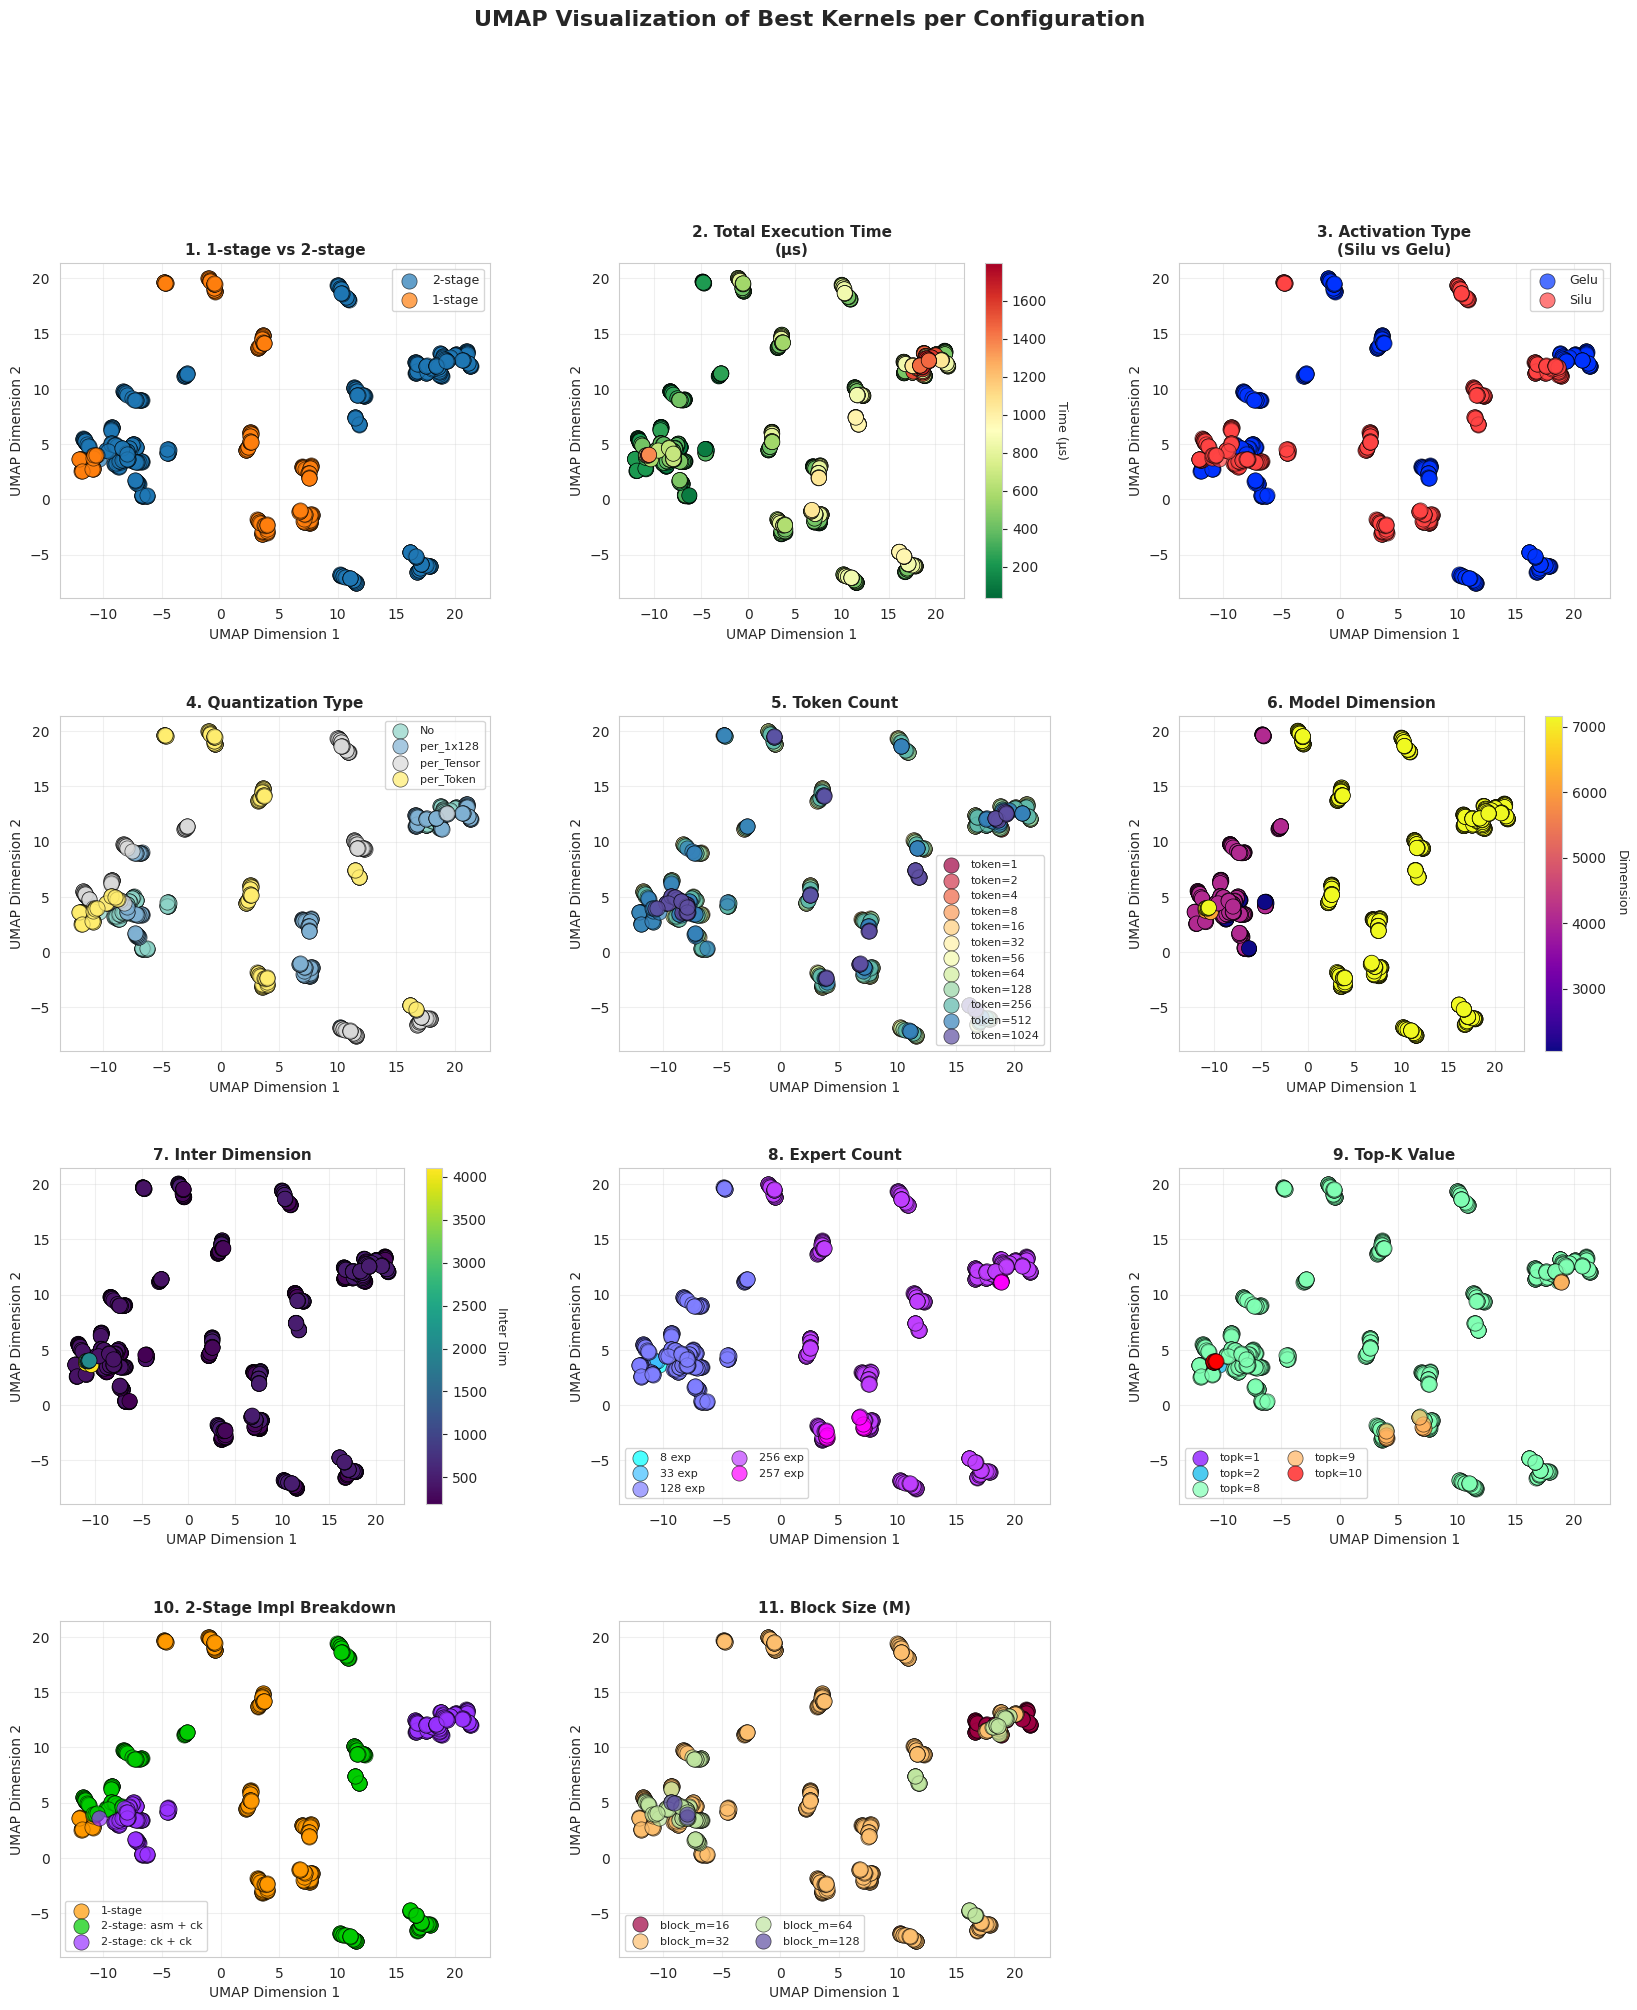


✓ Visualization saved as 'umap_best_kernels_11colorings.png'

Visualization Summary:
  Total configurations visualized: 679
  Unique approaches: 2
  Unique activation types: 2
  Unique quantization types: 4
  Token range: 1 - 1024
  Model dim range: 2048 - 7168
  Inter dim range: 192 - 4096
  Expert range: 8 - 257
  TopK range: 1 - 10
  Performance range: 34.48 - 1798.84 μs

Plot 3 (Activation Type) - IMPROVED COLOR SCHEME:
  Silu: Bright Red (#FF4444)
  Gelu: Deep Blue (#0033FF)

Plot 10 (2-Stage Implementation Breakdown) - DISTINCT COLORS:
  asm + ck: 210 configurations - Green (#00CC00)
  ck + ck: 232 configurations - Purple (#9933FF)


In [6]:
# ============================================================================
# Section 4: Extended Visualization - Best Kernels with Multiple Colorings
# ============================================================================
# This section visualizes the UMAP-reduced kernel configuration space with 
# various color schemes to reveal different patterns and insights

print("=" * 80)
print("SECTION 4: EXTENDED VISUALIZATIONS")
print("=" * 80)

# Create figure with 4 rows of plots (4x3 grid = 11 subplots)
fig = plt.figure(figsize=(20, 22))
gs = fig.add_gridspec(4, 3, hspace=0.35, wspace=0.3)

fig.suptitle('UMAP Visualization of Best Kernels per Configuration', 
             fontsize=16, fontweight='bold', y=0.995)

# Plot 1: Colored by Approach (1-stage vs 2-stage)
ax1 = fig.add_subplot(gs[0, 0])
for approach in best_per_config['approach'].unique():
    mask = best_per_config['approach'] == approach
    ax1.scatter(best_per_config[mask]['umap_1'], best_per_config[mask]['umap_2'], 
              label=approach, alpha=0.7, s=120, edgecolors='black', linewidth=0.5)
ax1.set_xlabel('UMAP Dimension 1', fontsize=10)
ax1.set_ylabel('UMAP Dimension 2', fontsize=10)
ax1.set_title('1. 1-stage vs 2-stage', fontweight='bold', fontsize=11)
ax1.legend(fontsize=9)
ax1.grid(True, alpha=0.3)

# Plot 2: Colored by Total Execution Time
ax2 = fig.add_subplot(gs[0, 1])
scatter = ax2.scatter(best_per_config['umap_1'], best_per_config['umap_2'], 
                    c=best_per_config['total_time_us'], cmap='RdYlGn_r', s=120, 
                    edgecolors='black', linewidth=0.5)
ax2.set_xlabel('UMAP Dimension 1', fontsize=10)
ax2.set_ylabel('UMAP Dimension 2', fontsize=10)
ax2.set_title('2. Total Execution Time\n(μs)', fontweight='bold', fontsize=11)
cbar = plt.colorbar(scatter, ax=ax2)
cbar.set_label('Time (μs)', rotation=270, labelpad=15, fontsize=9)
ax2.grid(True, alpha=0.3)

# Plot 3: Colored by Activation Type (with IMPROVED DISTINCT COLORS)
ax3 = fig.add_subplot(gs[0, 2])
act_types = sorted(best_per_config['act_type_clean'].unique())
# Use more distinct colors: Red for Silu, Deep Blue for Gelu
colors_act = {'Silu': '#FF4444', 'Gelu': '#0033FF'}  # Bright red vs Deep blue
for act in act_types:
    mask = best_per_config['act_type_clean'] == act
    color = colors_act.get(act, '#808080')  # Default gray if unknown
    ax3.scatter(best_per_config[mask]['umap_1'], best_per_config[mask]['umap_2'],
              label=act, alpha=0.7, s=120, color=color, edgecolors='black', linewidth=0.5)
ax3.set_xlabel('UMAP Dimension 1', fontsize=10)
ax3.set_ylabel('UMAP Dimension 2', fontsize=10)
ax3.set_title('3. Activation Type\n(Silu vs Gelu)', fontweight='bold', fontsize=11)
ax3.legend(fontsize=9, loc='best')
ax3.grid(True, alpha=0.3)

# Plot 4: Colored by Quantization Type
ax4 = fig.add_subplot(gs[1, 0])
q_types = best_per_config['q_type_clean'].unique()
colors = plt.cm.Set3(np.linspace(0, 1, len(q_types)))
for i, qtype in enumerate(sorted(q_types)):
    mask = best_per_config['q_type_clean'] == qtype
    ax4.scatter(best_per_config[mask]['umap_1'], best_per_config[mask]['umap_2'],
              label=qtype, alpha=0.7, s=120, color=colors[i], edgecolors='black', linewidth=0.5)
ax4.set_xlabel('UMAP Dimension 1', fontsize=10)
ax4.set_ylabel('UMAP Dimension 2', fontsize=10)
ax4.set_title('4. Quantization Type', fontweight='bold', fontsize=11)
ax4.legend(fontsize=8, loc='best')
ax4.grid(True, alpha=0.3)

# Plot 5: Colored by Token Count
ax5 = fig.add_subplot(gs[1, 1])
token_vals = sorted(best_per_config['token'].unique())
colors_token = plt.cm.Spectral(np.linspace(0, 1, len(token_vals)))
for i, token_val in enumerate(token_vals):
    mask = best_per_config['token'] == token_val
    ax5.scatter(best_per_config[mask]['umap_1'], best_per_config[mask]['umap_2'],
              label=f'token={int(token_val)}', alpha=0.7, s=120, color=colors_token[i], 
              edgecolors='black', linewidth=0.5)
ax5.set_xlabel('UMAP Dimension 1', fontsize=10)
ax5.set_ylabel('UMAP Dimension 2', fontsize=10)
ax5.set_title('5. Token Count', fontweight='bold', fontsize=11)
ax5.legend(fontsize=8, loc='best')
ax5.grid(True, alpha=0.3)

# Plot 6: Colored by Model Dimension
ax6 = fig.add_subplot(gs[1, 2])
scatter = ax6.scatter(best_per_config['umap_1'], best_per_config['umap_2'],
                    c=best_per_config['model_dim'], cmap='plasma', s=120,
                    edgecolors='black', linewidth=0.5)
ax6.set_xlabel('UMAP Dimension 1', fontsize=10)
ax6.set_ylabel('UMAP Dimension 2', fontsize=10)
ax6.set_title('6. Model Dimension', fontweight='bold', fontsize=11)
cbar = plt.colorbar(scatter, ax=ax6)
cbar.set_label('Dimension', rotation=270, labelpad=15, fontsize=9)
ax6.grid(True, alpha=0.3)

# Plot 7: Colored by Inter Dimension (FFN intermediate size)
ax7 = fig.add_subplot(gs[2, 0])
scatter = ax7.scatter(best_per_config['umap_1'], best_per_config['umap_2'],
                    c=best_per_config['inter_dim'], cmap='viridis', s=120,
                    edgecolors='black', linewidth=0.5)
ax7.set_xlabel('UMAP Dimension 1', fontsize=10)
ax7.set_ylabel('UMAP Dimension 2', fontsize=10)
ax7.set_title('7. Inter Dimension', fontweight='bold', fontsize=11)
cbar = plt.colorbar(scatter, ax=ax7)
cbar.set_label('Inter Dim', rotation=270, labelpad=15, fontsize=9)
ax7.grid(True, alpha=0.3)

# Plot 8: Colored by Expert Count
ax8 = fig.add_subplot(gs[2, 1])
expert_counts = sorted(best_per_config['expert'].unique())
colors_exp = plt.cm.cool(np.linspace(0, 1, len(expert_counts)))
for i, exp_count in enumerate(expert_counts):
    mask = best_per_config['expert'] == exp_count
    ax8.scatter(best_per_config[mask]['umap_1'], best_per_config[mask]['umap_2'],
              label=f'{int(exp_count)} exp', alpha=0.7, s=120, color=colors_exp[i], 
              edgecolors='black', linewidth=0.5)
ax8.set_xlabel('UMAP Dimension 1', fontsize=10)
ax8.set_ylabel('UMAP Dimension 2', fontsize=10)
ax8.set_title('8. Expert Count', fontweight='bold', fontsize=11)
ax8.legend(fontsize=8, loc='best', ncol=2)
ax8.grid(True, alpha=0.3)

# Plot 9: Colored by Top-K Value
ax9 = fig.add_subplot(gs[2, 2])
topk_vals = sorted(best_per_config['topk'].unique())
colors_topk = plt.cm.rainbow(np.linspace(0, 1, len(topk_vals)))
for i, topk_val in enumerate(topk_vals):
    mask = best_per_config['topk'] == topk_val
    ax9.scatter(best_per_config[mask]['umap_1'], best_per_config[mask]['umap_2'],
              label=f'topk={int(topk_val)}', alpha=0.7, s=120, color=colors_topk[i], 
              edgecolors='black', linewidth=0.5)
ax9.set_xlabel('UMAP Dimension 1', fontsize=10)
ax9.set_ylabel('UMAP Dimension 2', fontsize=10)
ax9.set_title('9. Top-K Value', fontweight='bold', fontsize=11)
ax9.legend(fontsize=8, loc='best', ncol=2)
ax9.grid(True, alpha=0.3)

# Plot 10: Approach with 2-Stage Implementation Breakdown (IMPROVED COLORS)
ax10 = fig.add_subplot(gs[3, 0])

# For 1-stage, keep as is
one_stage_mask = best_per_config['approach'] == '1-stage'
ax10.scatter(best_per_config[one_stage_mask]['umap_1'], best_per_config[one_stage_mask]['umap_2'],
            label='1-stage', alpha=0.7, s=120, color='#FF9900', edgecolors='black', linewidth=0.5)  # Orange

# For 2-stage, break down by stage1_kernel_type + stage2_kernel_type combination
two_stage_mask = best_per_config['approach'] == '2-stage'
two_stage_data = best_per_config[two_stage_mask].copy()

# Create combination of stage1 and stage2 implementations
two_stage_data['impl_combo'] = (two_stage_data['stage1_kernel_type'].fillna('Unknown') + 
                                 ' + ' + 
                                 two_stage_data['stage2_kernel_type'].fillna('Unknown'))

# Get unique combinations and assign DISTINCT colors (not all blue)
impl_combos = sorted(two_stage_data['impl_combo'].unique())
# Use custom distinct colors instead of tab10
colors_combo = {
    'asm + ck': '#00CC00',   # Green
    'ck + ck': '#9933FF',    # Purple
}

for combo in impl_combos:
    mask = two_stage_data['impl_combo'] == combo
    indices = two_stage_data[mask].index
    color = colors_combo.get(combo, '#CCCCCC')  # Default light gray if unknown
    ax10.scatter(best_per_config.loc[indices, 'umap_1'], 
                best_per_config.loc[indices, 'umap_2'],
                label=f'2-stage: {combo}', alpha=0.7, s=120, color=color, 
                edgecolors='black', linewidth=0.5)

ax10.set_xlabel('UMAP Dimension 1', fontsize=10)
ax10.set_ylabel('UMAP Dimension 2', fontsize=10)
ax10.set_title('10. 2-Stage Impl Breakdown', fontweight='bold', fontsize=11)
ax10.legend(fontsize=8, loc='best')
ax10.grid(True, alpha=0.3)

# Plot 11: Block Size (M dimension)
ax11 = fig.add_subplot(gs[3, 1])
block_sizes = sorted(best_per_config['block_m'].unique())
colors_block = plt.cm.Spectral(np.linspace(0, 1, len(block_sizes)))
for i, block in enumerate(block_sizes):
    mask = best_per_config['block_m'] == block
    ax11.scatter(best_per_config[mask]['umap_1'], best_per_config[mask]['umap_2'],
              label=f'block_m={int(block)}', alpha=0.7, s=120, color=colors_block[i], 
              edgecolors='black', linewidth=0.5)
ax11.set_xlabel('UMAP Dimension 1', fontsize=10)
ax11.set_ylabel('UMAP Dimension 2', fontsize=10)
ax11.set_title('11. Block Size (M)', fontweight='bold', fontsize=11)
ax11.legend(fontsize=8, loc='best', ncol=2)
ax11.grid(True, alpha=0.3)

plt.savefig('umap_best_kernels_11colorings.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n✓ Visualization saved as 'umap_best_kernels_11colorings.png'")
print(f"\nVisualization Summary:")
print(f"  Total configurations visualized: {len(best_per_config)}")
print(f"  Unique approaches: {best_per_config['approach'].nunique()}")
print(f"  Unique activation types: {best_per_config['act_type_clean'].nunique()}")
print(f"  Unique quantization types: {best_per_config['q_type_clean'].nunique()}")
print(f"  Token range: {best_per_config['token'].min()} - {best_per_config['token'].max()}")
print(f"  Model dim range: {best_per_config['model_dim'].min()} - {best_per_config['model_dim'].max()}")
print(f"  Inter dim range: {best_per_config['inter_dim'].min()} - {best_per_config['inter_dim'].max()}")
print(f"  Expert range: {best_per_config['expert'].min()} - {best_per_config['expert'].max()}")
print(f"  TopK range: {best_per_config['topk'].min()} - {best_per_config['topk'].max()}")
print(f"  Performance range: {best_per_config['total_time_us'].min():.2f} - {best_per_config['total_time_us'].max():.2f} μs")
print(f"\nPlot 3 (Activation Type) - IMPROVED COLOR SCHEME:")
print(f"  Silu: Bright Red (#FF4444)")
print(f"  Gelu: Deep Blue (#0033FF)")
print(f"\nPlot 10 (2-Stage Implementation Breakdown) - DISTINCT COLORS:")
impl_combos = sorted(two_stage_data['impl_combo'].unique())
color_map = {'asm + ck': 'Green (#00CC00)', 'ck + ck': 'Purple (#9933FF)'}
for combo in impl_combos:
    count = len(two_stage_data[two_stage_data['impl_combo'] == combo])
    color_name = color_map.get(combo, 'Gray')
    print(f"  {combo}: {count} configurations - {color_name}")